In [1]:
import numpy as np
import derpy
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from katsu.mueller import linear_polarizer, linear_retarder

# Getting Started with Derpy

_written by Jaren N. Ashcraft_

In this tutorial we review the startup procedure for the Derp polarimeter using the `derpy` control software.

## Turn on the CRED2 Camera
- 1) plug the cable in to the big brick, Dexter's laboratory style
- 2) remove cover slip protecting the sensor
- 3) Wait for person in lab to verify that the brick has been plugged in

Next we initialize 

In [2]:
cam = derpy.CRED2(set_temperature=-40, fps=10, tint=10) # TODO: add units to docstring (also add docstring)

Updating...
Sensor Temperature: -39.99C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.75C
Peltier Temperature: 14.11C
Heatsink Temperature: 40.16C
***********************
Sensor Temperature: -39.99C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.75C
Peltier Temperature: 14.11C
Heatsink Temperature: 40.16C
***********************
Sensor Temperature: -39.99C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.75C
Peltier Temperature: 14.11C
Heatsink Temperature: 40.16C
***********************
Sensor Temperature: -40.0C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.75C
Peltier Temperature: 14.1C
Heatsink Temperature: 40.15C
***********************
Final Sensor Temperature -39.99C
Prior camera tint: 0.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967610.0999967

In [48]:
cam.close()

We can plot the temperature to show the rate at which it cooled down

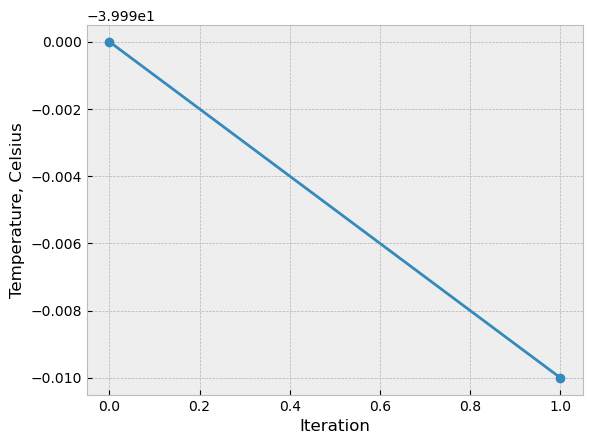

In [4]:
plt.style.use('bmh')
plt.figure()
plt.plot(cam.temperature_change, marker='o')
plt.ylabel('Temperature, Celsius')
plt.xlabel('Iteration')
plt.show()

## Focus Stage
We begin with the linear translation stage that the CRED2 camera is mounted on. First, let's print what connected devices we have available.

In [4]:
derpy.print_connected_devices()

[('55346494', 'Kinesis K10CR1 Rotary Stage'), ('55344714', 'Kinesis K10CR1 Rotary Stage'), ('45452684', 'APT Stepper Motor Controller')]


That last element called `APT Stepper Motor Controller` is what we will be targeting. This ID is pre-loaded into `derpy.derpy_conf` so configure the Focus Stage.

In [5]:
derpy.FOCUS_STAGE_ID

45452684

We begin by establishing a connection to the Focus Stage, this is done by initializing the `FocusStage` class.

In [6]:
fstg = derpy.FocusStage()

c:\Users\EPL User\.conda\envs\pylablib_env\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model LTS150C; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


Pylablib throws some warnings because the stage is not natively supported, so we will need to perform a calibration of the focus stage eventually.

In [20]:
fstg.step(-1e7)

## Rotation Stages

Next we will show how to connect to the rotation stages on Derp. Similarlly to the Focus Stage, we will initialize the `RotationStage` class which automatically connects to the correct stage ID.

In [5]:
psg_stg = derpy.PSGRotationStage()
psa_stg = derpy.PSARotationStage()

In [50]:
psg_stg.close()

## SuperK Laser
Yes it's actually called the SuperK laser. This is the final step in initializing Derp! 

TODO: Write setup procedure for SuperK

In [6]:
print(cam.min_tint)
print(cam.max_tint)

0.001373
99.996761


In [130]:
cam.tint = 5E-2

In [109]:
# import FliSdk_V2 as sdk
# sdk.Update(cam.context)
# res, response = sdk.FliCredTwo.GetTint(cam.context)
# print(response)

1.1694e-05


In [10]:
dark = cam.take_image()[0]

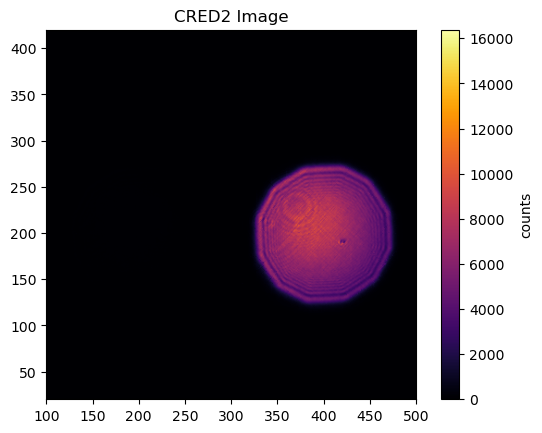

In [11]:
plt.style.use('default')
from matplotlib.colors import LogNorm
cut = 200
xc, yc = 300, 220
ims = cam.take_many_images(5)
im = np.median(ims, axis=0) - dark
im[im < 0] = 1e-20

plt.figure()
plt.title('CRED2 Image')
plt.imshow(im, cmap='inferno', vmax=2**14, vmin=0)
plt.xlim(xc-cut, xc+cut)
plt.ylim(yc-cut, yc+cut)
plt.colorbar(label='counts')

In [12]:
# calibrate PSG
TH_STEP = 5
psg_angles_cal = np.arange(0, 180 + TH_STEP, TH_STEP)
power_observed_psg = []
for th in psg_angles_cal:
    psg_stg.step(TH_STEP)
    sleep(0.5)
    _ims = cam.take_many_images(5)
    _im = np.median(_ims, axis=0) - dark
    _im[im < 0] = 1e-20
    power_observed_psg.append(_im[yc-cut:yc+cut, xc-cut:xc+cut])

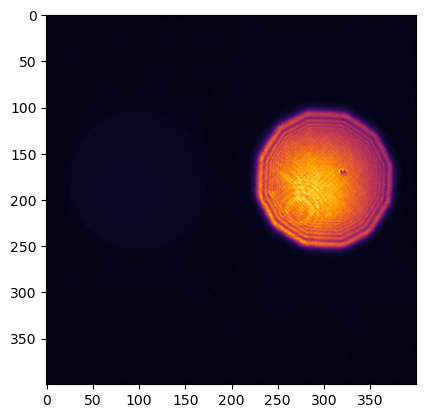

In [13]:
plt.imshow(power_observed_psg[0], cmap='inferno')

In [14]:
left_x, left_y = 175, 100
right_x, right_y = 175, 300
crop_circle = 75

cropped_left_psg = []
cropped_right_psg = []

for p in power_observed_psg:
    cropped_left_psg.append(p[left_x-crop_circle:left_x+crop_circle, left_y-crop_circle:left_y+crop_circle])
    cropped_right_psg.append(p[right_x-crop_circle:right_x+crop_circle, right_y-crop_circle:right_y+crop_circle])

In [15]:
x = np.linspace(-1, 1, cropped_right_psg[0].shape[0])
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 0.5] = 1

In [25]:
mean_left_psg = []
mean_right_psg = []
for pl, pr in zip(cropped_left_psg, cropped_right_psg):
    mean_left_psg.append(np.mean(pl[mask==1]))
    mean_right_psg.append(np.mean(pr[mask==1]))

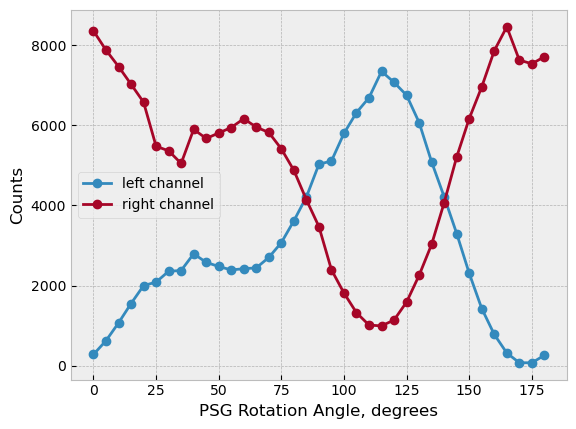

In [26]:
plt.style.use('bmh')
plt.figure()
plt.plot(psg_angles_cal, mean_left_psg, label='left channel', marker='o')
plt.plot(psg_angles_cal, mean_right_psg, label='right channel', marker='o')
plt.legend()
plt.xlabel('PSG Rotation Angle, degrees')
plt.ylabel('Counts')
plt.show()

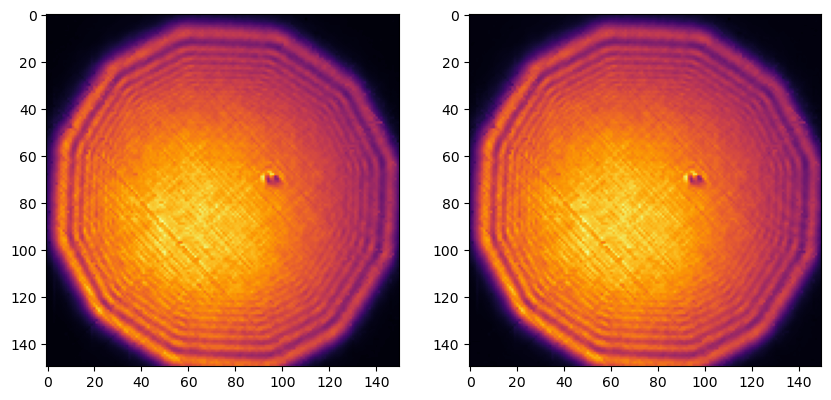

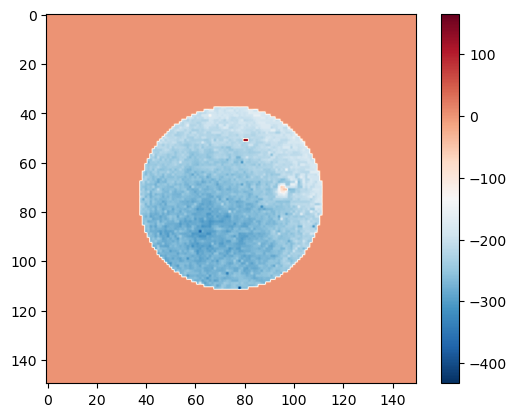

In [27]:
plt.style.use('default')
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(cropped_right_psg[-4], cmap='inferno')
plt.subplot(122)
plt.imshow(cropped_right_psg[-2], cmap='inferno')
plt.show()

plt.figure()
plt.imshow(mask * (cropped_left_psg[-2] - cropped_left_psg[-4]), cmap='RdBu_r')
plt.colorbar()
plt.show()

Note that the PSG retarder has rotated 180 deg from original position

In [28]:
# calibrate PSA
TH_STEP = 5
psa_angles_cal = np.arange(0, 180 + TH_STEP, TH_STEP)
power_observed_psa = []
for th in psg_angles_cal:
    psa_stg.step(TH_STEP)
    sleep(0.5)
    _ims = cam.take_many_images(5)
    _im = np.median(_ims, axis=0) - dark
    _im[im < 0] = 1e-20
    power_observed_psa.append(_im[yc-cut:yc+cut, xc-cut:xc+cut])

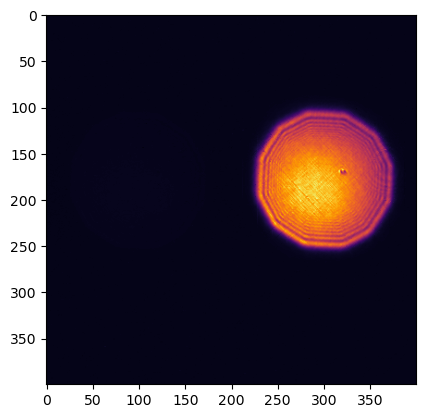

In [29]:
plt.imshow(power_observed_psa[0], cmap='inferno')

In [30]:
cropped_left_psa = []
cropped_right_psa = []

for p in power_observed_psa:
    cropped_left_psa.append(p[left_x-crop_circle:left_x+crop_circle, left_y-crop_circle:left_y+crop_circle])
    cropped_right_psa.append(p[right_x-crop_circle:right_x+crop_circle, right_y-crop_circle:right_y+crop_circle])

In [31]:
mean_left_psa = []
mean_right_psa = []
for pl, pr in zip(cropped_left_psa, cropped_right_psa):
    mean_left_psa.append(np.mean(pl[mask==1]))
    mean_right_psa.append(np.mean(pr[mask==1]))

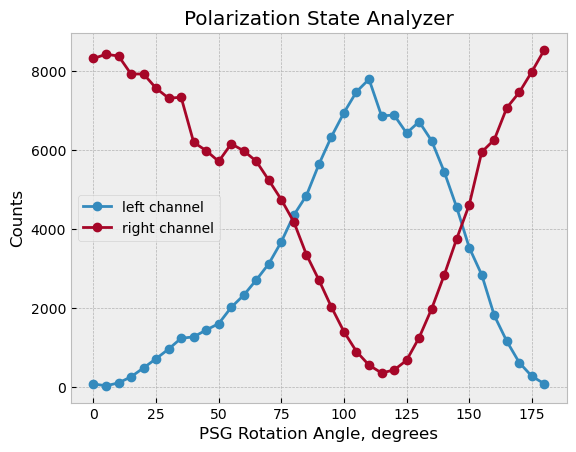

In [32]:
plt.style.use('bmh')
plt.figure()
plt.title('Polarization State Analyzer')
plt.plot(psa_angles_cal, mean_left_psa, label='left channel', marker='o')
plt.plot(psa_angles_cal, mean_right_psa, label='right channel', marker='o')
plt.legend()
plt.xlabel('PSG Rotation Angle, degrees')
plt.ylabel('Counts')
plt.show()

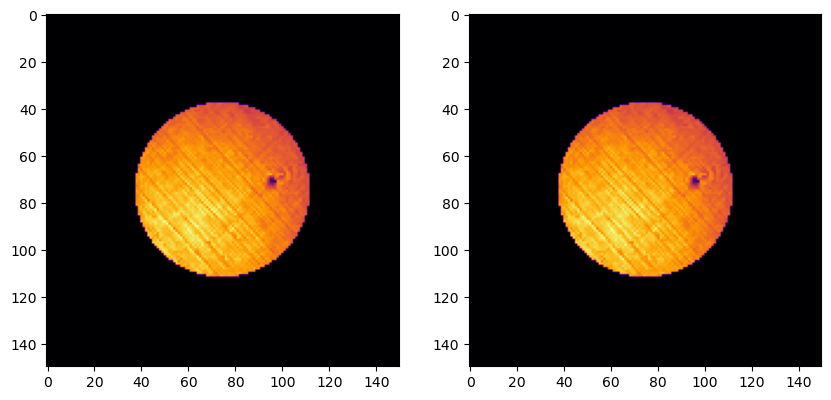

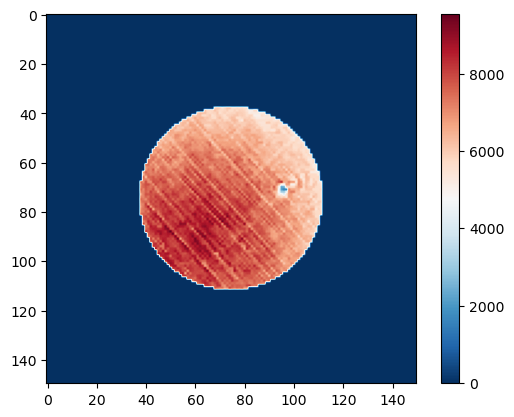

In [35]:
plt.style.use('default')
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(cropped_left_psa[-15] * mask, cmap='inferno')
plt.subplot(122)
plt.imshow(cropped_left_psa[-13] * mask, cmap='inferno')
plt.show()

plt.figure()
plt.imshow(mask * (cropped_left_psa[-15] - cropped_left_psa[-3]), cmap='RdBu_r')
plt.colorbar()
plt.show()

In [36]:
def fwd_calibrate(x, which='psg', channel='left'):

    # theta -> starting angle, nominal 0 degrees
    # delta -> retardance, nominal 45 degrees
    # phi -> angular increment, nominal 5 degrees
    angles = np.arange(0, 185, 5)
    angles = np.radians(angles)

    psg_pol_theta = x[0]

    psg_ret_theta = x[1]
    psg_ret_delta = x[2]
    psg_ret_phi = x[3]

    psa_ret_theta = x[4]
    psa_ret_delta = x[4]
    psa_ret_phi = x[4]

    psg_pol = linear_polarizer(psg_pol_theta, shape=[len(angles)])
    
    if which=='psg':
        psg_ret = linear_retarder(angles*psg_ret_phi + psg_ret_theta, psg_ret_delta, shape=[len(angles)])
        psa_ret = linear_retarder(psa_ret_theta, psa_ret_delta, shape=[len(angles)])

    elif which=='psa':
        psg_ret = linear_retarder(psg_ret_theta, psg_ret_delta, shape=[len(angles)])
        psa_ret = linear_retarder(angles*psa_ret_phi + psa_ret_theta, psa_ret_delta, shape=[len(angles)])

    if channel=='left':
        psa_pol = linear_polarizer(np.radians(90), shape=[len(angles)])
    elif channel=='right':
        psa_pol = linear_polarizer(np.radians(0), shape=[len(angles)])

    # construct the Mueller matrix
    M = psa_pol @ psa_ret @ psg_ret @ psg_pol

    return M[..., 0, 0]
    

In [46]:
%%timeit
x0 = [0, 0, np.radians(45), 1, np.pi/4, np.radians(45), 1]
power = fwd_calibrate(x0)

205 μs ± 3.29 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


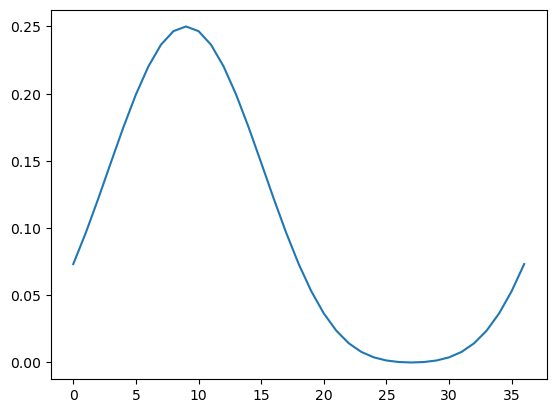

In [47]:
plt.plot(power)

C:\Users\EPL User\AppData\Local\Temp\ipykernel_11296\3545405141.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(im), cmap='inferno', vmax=4, vmin=0)


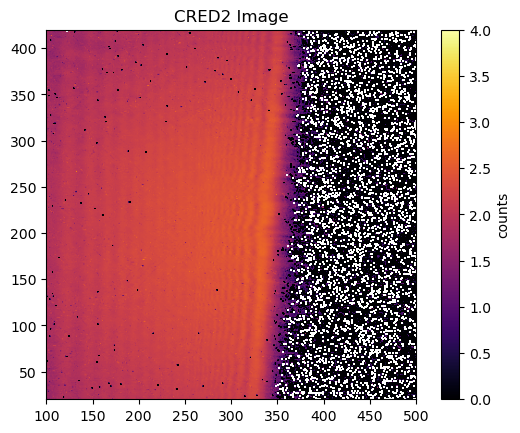

In [119]:
plt.style.use('default')
from matplotlib.colors import LogNorm
cut = 200
xc, yc = 300, 220
ims = cam.take_many_images(5)
im = np.median(ims, axis=0) - dark
im[im < 0] = 1e-20

plt.figure()
plt.title('CRED2 Image')
plt.imshow(np.log10(im), cmap='inferno', vmax=4, vmin=0)
plt.xlim(xc-cut, xc+cut)
plt.ylim(yc-cut, yc+cut)
plt.colorbar(label='counts')

1520.015625


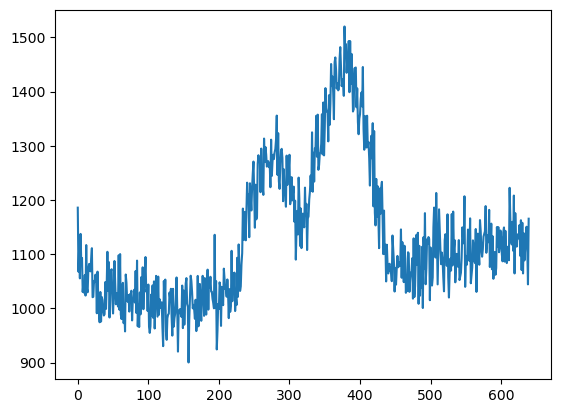

In [132]:
plt.plot(np.mean(im, axis=0))
print(np.mean(im,axis=0).max())

In [134]:
from derpy.experiments import autofocus_stage

In [252]:
# record current max brightness
brightvals = []
brightpros = []
i = 0
repetition_depth = 10
verbose = True
maxiters = 50
step_size = 5e5

# take an initial image
def _combine(dark=None):
    
    im = cam.take_many_images(10)

    if dark is not None:
        for i, _ in enumerate(im):
            im[i] -= dark

    im_med = np.mean(im, axis=0)
    profile_mean = np.mean(im_med, axis=0)

    return profile_mean

med_start = _combine()
max_start = np.max(med_start)

# move the stage by one step
while (repetition_depth > 0) and (i < maxiters):

    i += 1

    fstg.step(step_size)
    mean_end = _combine()
    max_end = np.max(mean_end)

    if max_start > max_end:
        if verbose:
            print("DIRECTION CHANGE")
        step_size /= -2
        repetition_depth -= 1

    max_start = max_end
    brightvals.append(max_end)
    brightpros.append(mean_end)
    if verbose:
        print(f"iteration {i}, rep depth {repetition_depth}, brighness: {max_end}")

    sleep(0.1)

iteration 1, rep depth 10, brighness: 1228.720703125
iteration 2, rep depth 10, brighness: 1230.14453125
iteration 3, rep depth 10, brighness: 1231.150390625
iteration 4, rep depth 10, brighness: 1233.15625
iteration 5, rep depth 10, brighness: 1518.515625
DIRECTION CHANGE
iteration 6, rep depth 9, brighness: 1236.298828125
iteration 7, rep depth 9, brighness: 1238.146484375
iteration 8, rep depth 9, brighness: 1238.751953125
iteration 9, rep depth 9, brighness: 1240.98046875
iteration 10, rep depth 9, brighness: 1241.685546875
iteration 11, rep depth 9, brighness: 1243.89453125
iteration 12, rep depth 9, brighness: 1245.462890625
iteration 13, rep depth 9, brighness: 1246.8125
iteration 14, rep depth 9, brighness: 1248.341796875
iteration 15, rep depth 9, brighness: 1404.1796875
iteration 16, rep depth 9, brighness: 1726.107421875
DIRECTION CHANGE
iteration 17, rep depth 8, brighness: 1422.17578125
iteration 18, rep depth 8, brighness: 1490.240234375
DIRECTION CHANGE
iteration 19, rep

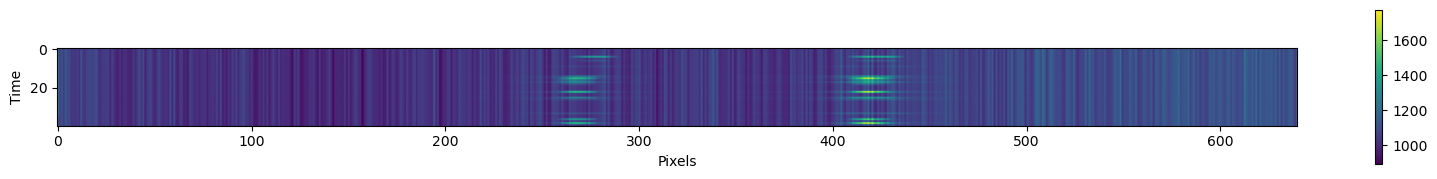

In [277]:
plt.figure(figsize=[20,2])
plt.imshow(np.asarray(brightpros))
plt.colorbar()
plt.ylabel('Time')
plt.xlabel('Pixels')
plt.show()

In [278]:
cam.close()

In [183]:
fstg.step(1e7)

In [264]:
cam.tint = 5e-2

In [267]:
im = cam.take_image()[0]

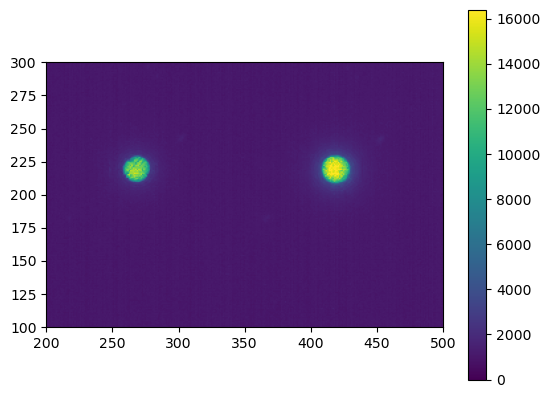

In [269]:
plt.imshow(im, vmax=2**14)
plt.xlim([200, 500])
plt.ylim([100, 300])
plt.colorbar()

In [249]:
sdk.IsSerialCamera(cam.context)

True

In [258]:
cam.fps = 50

In [202]:
np.median(im)

1051.0

## Take a Test Image

73462640

In [283]:
dark = cam.take_many_images(10)

In [284]:
dark_med = np.median(dark, axis=0)

In [282]:
cam.tint = 0.05

In [300]:
cam.fps = 120

In [237]:
fstg.step(-1e6)

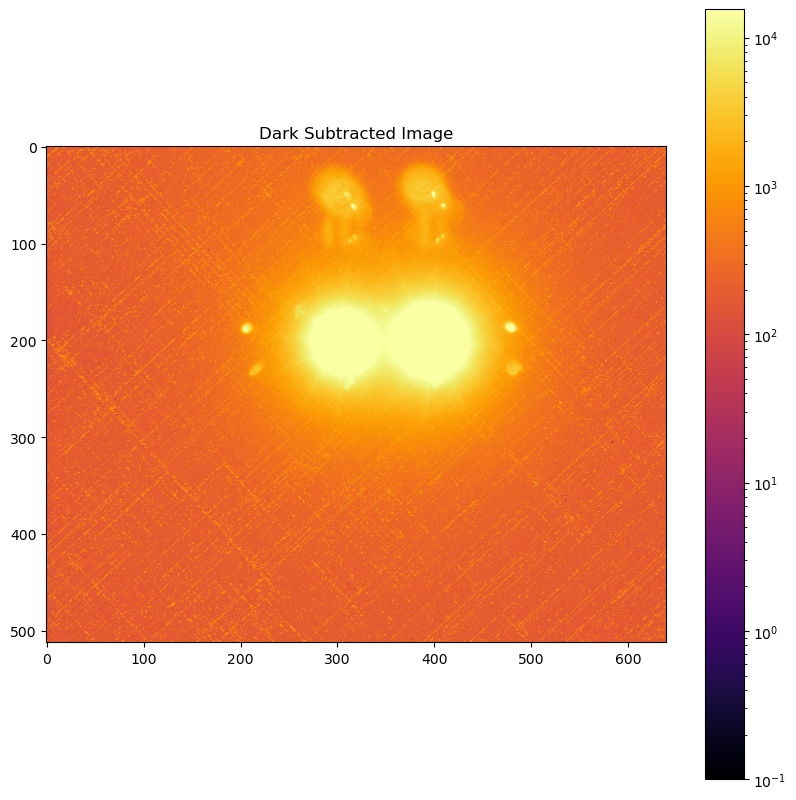

In [301]:
im = cam.take_many_images(10)
sleep(1)
im_med = np.median(im, axis=0)

vlim = None
cx, cy = 325, 200
cut = 200

processed = im_med.astype(np.float64) - dark_med.astype(np.float64)
processed[processed < 0] = 1e-10

plt.figure(figsize=[10, 10])
plt.title('Dark Subtracted Image')
plt.imshow(processed, cmap='inferno', norm=LogNorm(vmax=vlim, vmin=1e-1))
# plt.xlim(cx-cut, cx+cut)
# plt.ylim(cy-cut, cy+cut)
plt.colorbar()
plt.show()

# Testing Focus, Rotation Stages

In [2]:
derpy.print_connected_devices()

[('45452684', 'APT Stepper Motor Controller'), ('55344714', 'Kinesis K10CR1 Rotary Stage'), ('55346494', 'Kinesis K10CR1 Rotary Stage')]


In [3]:
fstg = derpy.FocusStage()

c:\Users\EPL User\.conda\envs\pylablib_env\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model LTS150C; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [4]:
psgstg = derpy.PSGRotationStage()
psastg = derpy.PSARotationStage()

In [5]:
psgstg.step(10)

In [6]:
psastg.step(10)

In [7]:
fstg.step(500000)

In [4]:
fstg.close()
psgstg.close()
psastg.close()

NameError: name 'psgstg' is not defined

# Testing CRED2 Camera

In [2]:
cam = derpy.CRED2(-39, fps=10, tint=1000)

Updating...
Sensor Temperature: -37.88C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 43.75C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.5C
***********************
Sensor Temperature: -37.88C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.48C
***********************
Sensor Temperature: -37.88C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.48C
***********************
Sensor Temperature: -35.59C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 15.04C
Heatsink Temperature: 38.69C
***********************
Sensor Temperature: -37.82C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.25C
Peltier Temperature: 13.76C
Heatsink Temperature: 39.24C
******************

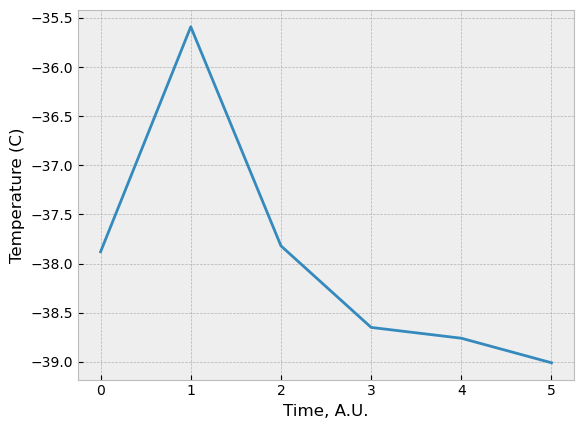

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

plt.figure()
plt.ylabel('Temperature (C)')
plt.xlabel('Time, A.U.')
plt.plot(cam.temperature_change, label='Temperature Change')
plt.show()

In [4]:
im = cam.take_image()

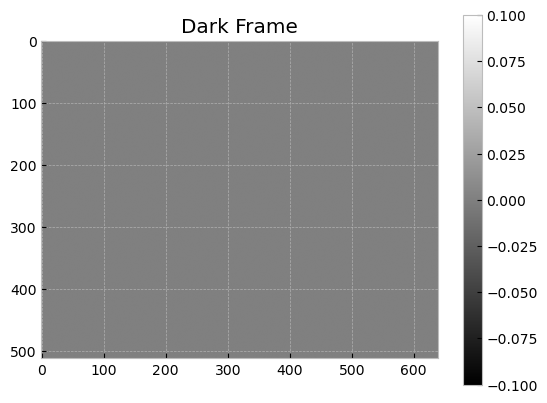

In [8]:
plt.figure()
plt.title('Dark Frame')
plt.imshow(im[0], cmap='gray')
plt.colorbar()
plt.show()

In [9]:
im[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
cam.close()

In [44]:
cam.tint = 50 # ms

In [56]:
im_light_50ms = cam.take_image()[0]
im_light_50ms.dtype

dtype('float64')

In [17]:
import FliSdk_V2 as sdk

im = sdk.GetRawImageAsNumpyArray(cam.context,0)

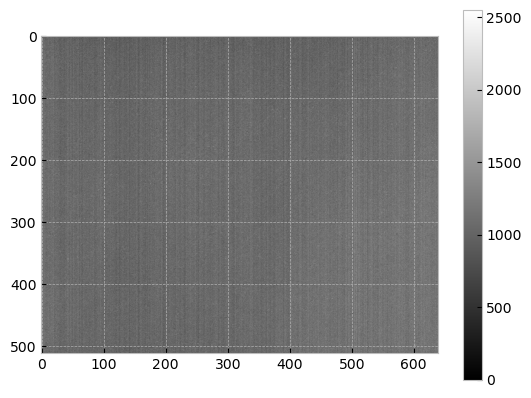

In [22]:
plt.imshow(im, cmap='gray', vmax=2550)
plt.colorbar()

In [32]:
im_light = sdk.GetRawImageAsNumpyArray(cam.context,0)

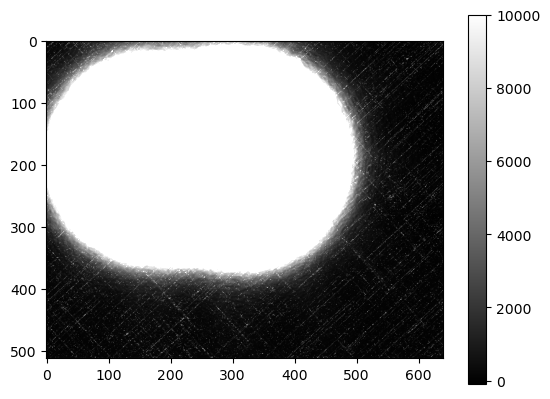

In [57]:
plt.style.use('default')
plt.imshow(im_light_50ms - im.astype(np.float64), cmap='gray',vmin=-100, vmax=10000)
plt.colorbar()